# Goal

You need to estimate the total flow of oil, gas, and water through a choke valve. The total flow rate is labeled `QTOT`. You should use all measurements that may explain the total flow. Awesome Corp has already prepared these for you in a dataset (no further preprocessing is required). The measurements (features) are labeled as follows:
- `CHK`: choke opening - a number in [0, 1], 1 meaning fully open and 0 meaning closed
- `PWH`: pressure upstream the choke (scaled)
- `PDC`: pressure downstream the choke (scaled)
- `TWH`: temperature upstream the choke (scaled)
- `FGAS`: fraction of gas to total flow - a number in [0,1]
- `FOIL`: fraction of water to total flow - a number in [0,1]

The location of the sensors are shown in the figure below.

<img src="well_sensors.png">

### Wait! There is one issue. The customer does not have a model for the total flow rate...

A simple choke model for water flow is:
$$QTOT = C_v(CHK) \sqrt{\frac{2(PWH - PDC)}{\rho}}$$
where $C_v(CHK)$ gives the cross-sectional area as a function of choke opening `CHK`.

Unfortunately, there are complications that prevent us from using this model:

1. We do not know what the correct equations are for multi-phase flow. For example, we expect gas expansions to be a factor. This factor is likely dependent on the temperature `TWH` and the amount of gas `FGAS`. Viscosity is probably a factor too, and that would depend on `FOIL`.
2. We do not know the form of the choke $C_v$-curve.

[Head scratch] Perhaps we can use a deep learning algorithm to learn a good representation of the data? Let us try to use all the available measurements to model `QTOT` using a neural network:
$$QTOT = f_{\theta}(CHK, PWH, PDC, TWH, FGAS, FOIL)$$

Let's get to work!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam


# Dataset

In [2]:
df = pd.read_csv('well_data.csv', index_col=0)
df

,CHK,PWH,PDC,TWH,FGAS,FOIL,QTOT
0,0.540,0.542755,0.211586,0.594760,0.138882,0.861118,32.358228
1,0.540,0.542755,0.211586,0.594760,0.142222,0.857774,32.940225
2,0.894,0.458000,0.222654,0.616555,0.144697,0.855303,48.633042
3,0.894,0.452311,0.222556,0.609029,0.144938,0.855056,48.065657
4,0.894,0.443485,0.221839,0.602488,0.144187,0.855807,47.096656
...,...,...,...,...,...,...,...
3094,0.534,0.462606,0.215561,0.592627,0.128039,0.826061,28.108285
3095,0.534,0.462854,0.216331,0.589506,0.127935,0.825378,28.119254
3096,0.534,0.463855,0.239411,0.594895,0.127857,0.824711,27.875849
3097,0.415,0.498174,0.234317,0.581882,0.129256,0.833875,18.412828


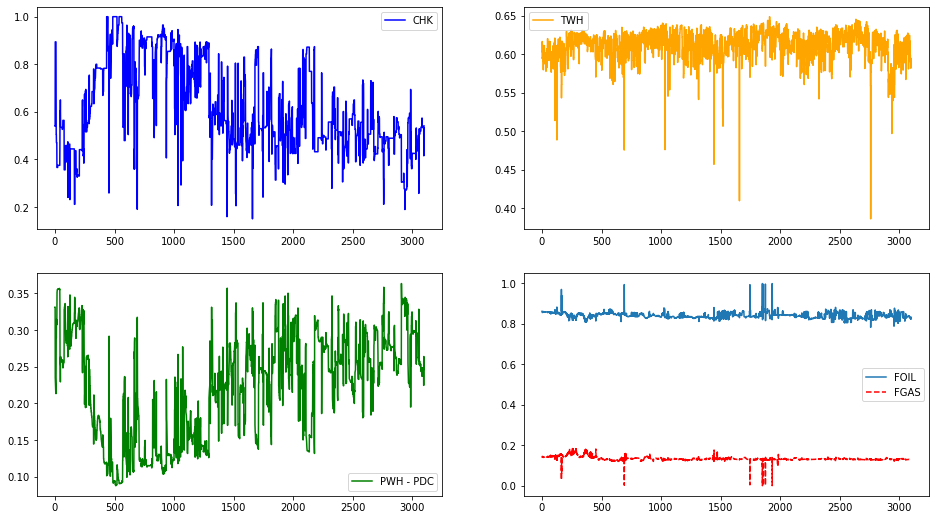

In [3]:
fig, ax = plt.subplots(2, 2, figsize=(16, 9))

# Choke valve opening
ax[0, 0].plot(df['CHK'], label='CHK', color="blue")
ax[0, 0].legend()

# Total floqw through choke valve
ax[0, 1].plot(df['TWH'], label='TWH', color='orange')
ax[0, 1].legend()

# Diff pressure over choke valve
ax[1, 0].plot(df['PWH'] - df['PDC'], label='PWH - PDC', color='green')
ax[1, 0].legend()

# Fractions
ax[1, 1].plot(df['FOIL'], label='FOIL')
ax[1, 1].plot(df['FGAS'], '--r', label='FGAS')
ax[1, 1].legend()

In [4]:
df.corr()

,CHK,PWH,PDC,TWH,FGAS,FOIL,QTOT
CHK,1.000000,-0.963694,0.706279,0.285622,0.091705,-0.087384,0.935945
PWH,-0.963694,1.000000,-0.690669,-0.262040,-0.053365,0.097010,-0.889464
PDC,0.706279,-0.690669,1.000000,0.086445,-0.071751,-0.103538,0.647044
TWH,0.285622,-0.262040,0.086445,1.000000,0.070121,-0.096992,0.372099
FGAS,0.091705,-0.053365,-0.071751,0.070121,1.000000,-0.375864,0.189640
FOIL,-0.087384,0.097010,-0.103538,-0.096992,-0.375864,1.000000,-0.096468
QTOT,0.935945,-0.889464,0.647044,0.372099,0.189640,-0.096468,1.000000


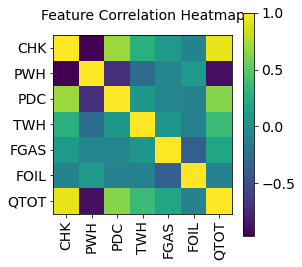

In [5]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)

## Split into training, validation and test data.

### Test data

In [6]:
test_set = df[2000:2500]

x_test = test_set.drop(columns='QTOT')
y_test = test_set[['QTOT']]

### Validation data

In [7]:
train_val_set = df.copy().drop(test_set.index) 
#train_val_set = df.iloc[0:500]

val_set = train_val_set.sample(frac=0.1, replace=False)

x_val = val_set.drop(columns='QTOT')
y_val = val_set[['QTOT']]

### Training data

In [8]:
train_set = train_val_set.copy().drop(val_set.index)

x_train = train_set.drop(columns='QTOT')
y_train = train_set[['QTOT']]

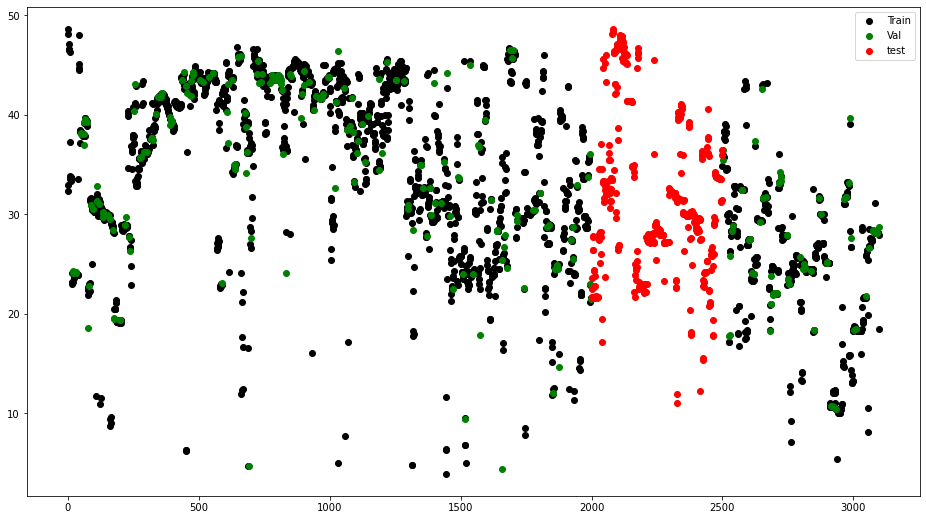

In [9]:
plt.figure(figsize=(16,9))
plt.scatter(y_train.index, y_train.values, color='black', label='Train')
plt.scatter(val_set.index, val_set['QTOT'], color='green', label='Val')
plt.scatter(y_test.index, y_test.values, color='red', label='test')
plt.legend()

# Simple model

In [10]:
from keras import regularizers

input_layer_size = x_train.columns.size

model = keras.Sequential()
model.add(keras.layers.Dense(input_layer_size, activation='relu', input_shape=(input_layer_size,)))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(1))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 42        
_________________________________________________________________
dense_1 (Dense)              (None, 128)               896       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 9,259
Trainable params: 9,259
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [13]:
history = model.fit(x_train,y_train,validation_data=(x_val, y_val),epochs=200, batch_size=10,verbose=2)

Epoch 1/200
234/234 - 0s - loss: 289.1052 - val_loss: 43.6839
Epoch 2/200
234/234 - 0s - loss: 33.4077 - val_loss: 19.3762
Epoch 3/200
234/234 - 0s - loss: 14.0483 - val_loss: 11.5379
Epoch 4/200
234/234 - 0s - loss: 10.4321 - val_loss: 11.1488
Epoch 5/200
234/234 - 0s - loss: 10.0513 - val_loss: 10.2737
Epoch 6/200
234/234 - 0s - loss: 9.5593 - val_loss: 10.2561
Epoch 7/200
234/234 - 0s - loss: 9.2732 - val_loss: 10.1879
Epoch 8/200
234/234 - 0s - loss: 9.0664 - val_loss: 9.9848
Epoch 9/200
234/234 - 0s - loss: 8.7501 - val_loss: 11.2314
Epoch 10/200
234/234 - 0s - loss: 8.3489 - val_loss: 8.4704
Epoch 11/200
234/234 - 0s - loss: 8.0121 - val_loss: 8.2734
Epoch 12/200
234/234 - 0s - loss: 7.8106 - val_loss: 8.6320
Epoch 13/200
234/234 - 0s - loss: 7.4914 - val_loss: 8.6489
Epoch 14/200
234/234 - 0s - loss: 7.4872 - val_loss: 7.8015
Epoch 15/200
234/234 - 0s - loss: 7.1471 - val_loss: 9.1918
Epoch 16/200
234/234 - 0s - loss: 6.9868 - val_loss: 10.5630
Epoch 17/200
234/234 - 0s - loss: 

Epoch 137/200
234/234 - 0s - loss: 4.0939 - val_loss: 4.6160
Epoch 138/200
234/234 - 0s - loss: 4.3386 - val_loss: 4.3637
Epoch 139/200
234/234 - 0s - loss: 3.9235 - val_loss: 5.1645
Epoch 140/200
234/234 - 0s - loss: 4.1451 - val_loss: 4.5611
Epoch 141/200
234/234 - 0s - loss: 4.0496 - val_loss: 4.6974
Epoch 142/200
234/234 - 0s - loss: 4.0004 - val_loss: 4.4127
Epoch 143/200
234/234 - 0s - loss: 4.1499 - val_loss: 4.4674
Epoch 144/200
234/234 - 0s - loss: 3.9900 - val_loss: 4.7620
Epoch 145/200
234/234 - 0s - loss: 4.1193 - val_loss: 4.2905
Epoch 146/200
234/234 - 0s - loss: 4.2179 - val_loss: 4.1224
Epoch 147/200
234/234 - 0s - loss: 3.9626 - val_loss: 4.3503
Epoch 148/200
234/234 - 0s - loss: 3.9427 - val_loss: 4.2224
Epoch 149/200
234/234 - 0s - loss: 3.8914 - val_loss: 4.2918
Epoch 150/200
234/234 - 0s - loss: 4.1061 - val_loss: 4.5361
Epoch 151/200
234/234 - 0s - loss: 3.9581 - val_loss: 4.4070
Epoch 152/200
234/234 - 0s - loss: 3.9838 - val_loss: 6.3917
Epoch 153/200
234/234 - 

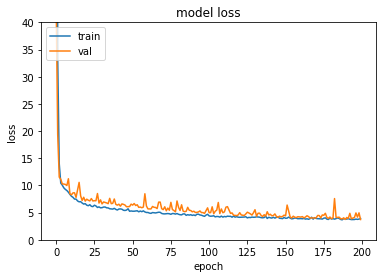

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
axes = plt.gca()
axes.set_ylim([0,40])
plt.show()

In [15]:
keras_predictions = model.predict(x_test, verbose=2)

16/16 - 0s


In [16]:

print("Error on test data simple model")
mse_test_simple = np.mean(np.power(keras_predictions - y_test.values, 2))
print("MSE: ", mse_test_simple) #2.6873526

mae_test_simple = np.mean(np.abs(keras_predictions-y_test.values))
print("MAE: ", mae_test_simple) # 1.12

mape_test_simple = 100*np.mean(np.abs(np.divide(keras_predictions - y_test.values, y_test.values)))
print("MAPE: ", mape_test_simple, "%") # 3.574



Error on test data simple model
MSE:  2.278323383344527
MAE:  1.0195811244905308
MAPE:  3.1558359298915475 %


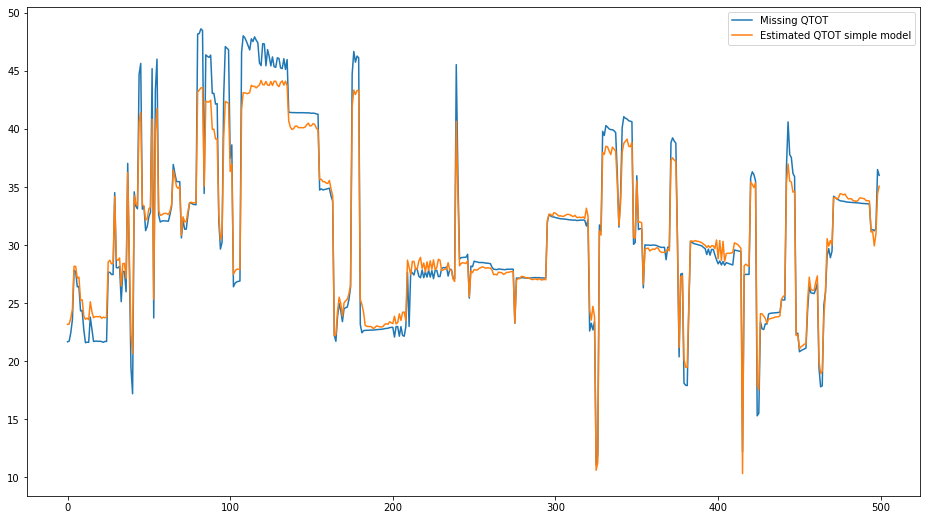

In [17]:
plt.figure(figsize=(16,9))
plt.plot(y_test.values, label='Missing QTOT')
plt.plot(keras_predictions, label='Estimated QTOT simple model')
plt.legend()

# Improve model

### Adding a dropout layer

In [18]:
from keras.layers import Dropout

input_layer_size = x_train.columns.size

improved_model = keras.Sequential()
improved_model.add(keras.layers.Dense(input_layer_size, activation='relu', input_shape=(input_layer_size,)))
model.add(keras.layers.Dropout(0.4))
improved_model.add(keras.layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.Dropout(0.4))
improved_model.add(keras.layers.Dense(1))

In [19]:
improved_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 56        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 107
Trainable params: 107
Non-trainable params: 0
_________________________________________________________________


In [20]:
improved_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

### Early stopping

In [21]:
from keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestClassifier

callback = EarlyStopping(monitor='val_loss', patience=5)


improved_history = improved_model.fit(x_train,y_train,validation_data=(x_val, y_val),epochs=200, batch_size=10, callbacks=[callback],verbose=2)

Epoch 1/200
234/234 - 0s - loss: 1099.1946 - val_loss: 931.9532
Epoch 2/200
234/234 - 0s - loss: 569.5018 - val_loss: 204.8440
Epoch 3/200
234/234 - 0s - loss: 94.5681 - val_loss: 54.9847
Epoch 4/200
234/234 - 0s - loss: 56.3546 - val_loss: 49.5430
Epoch 5/200
234/234 - 0s - loss: 49.4939 - val_loss: 41.8753
Epoch 6/200
234/234 - 0s - loss: 41.1221 - val_loss: 33.9830
Epoch 7/200
234/234 - 0s - loss: 32.8175 - val_loss: 26.2403
Epoch 8/200
234/234 - 0s - loss: 25.2323 - val_loss: 20.2467
Epoch 9/200
234/234 - 0s - loss: 19.1912 - val_loss: 15.1294
Epoch 10/200
234/234 - 0s - loss: 14.7647 - val_loss: 12.3466
Epoch 11/200
234/234 - 0s - loss: 12.0841 - val_loss: 10.7064
Epoch 12/200
234/234 - 0s - loss: 10.5443 - val_loss: 9.8874
Epoch 13/200
234/234 - 0s - loss: 9.6144 - val_loss: 9.4316
Epoch 14/200
234/234 - 0s - loss: 8.9339 - val_loss: 9.1696
Epoch 15/200
234/234 - 0s - loss: 8.5019 - val_loss: 8.9796
Epoch 16/200
234/234 - 0s - loss: 8.1498 - val_loss: 8.5734
Epoch 17/200
234/234 

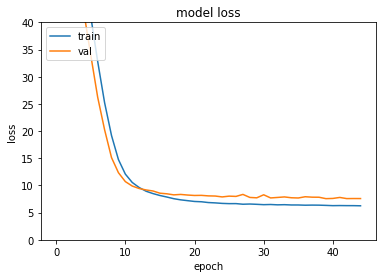

In [22]:
plt.plot(improved_history.history['loss'])
plt.plot(improved_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
axes = plt.gca()
axes.set_ylim([0,40])
plt.show()

In [23]:
improved_keras_predictions = improved_model.predict(x_test, verbose=2)

16/16 - 0s


In [24]:

print("Error on test data improved model")
mse_test_improved = np.mean(np.power(improved_keras_predictions - y_test.values, 2))
print("MSE: ", mse_test_improved) #2.6873526

mae_test_improved = np.mean(np.abs(improved_keras_predictions-y_test.values))
print("MAE: ", mae_test_improved) # 1.12

mape_test_improved = 100*np.mean(np.abs(np.divide(improved_keras_predictions - y_test.values, y_test.values)))
print("MAPE: ", mape_test_improved, "%") # 3.574



Error on test data improved model
MSE:  3.3677123357821688
MAE:  1.3055162872494097
MAPE:  3.8544066955440637 %


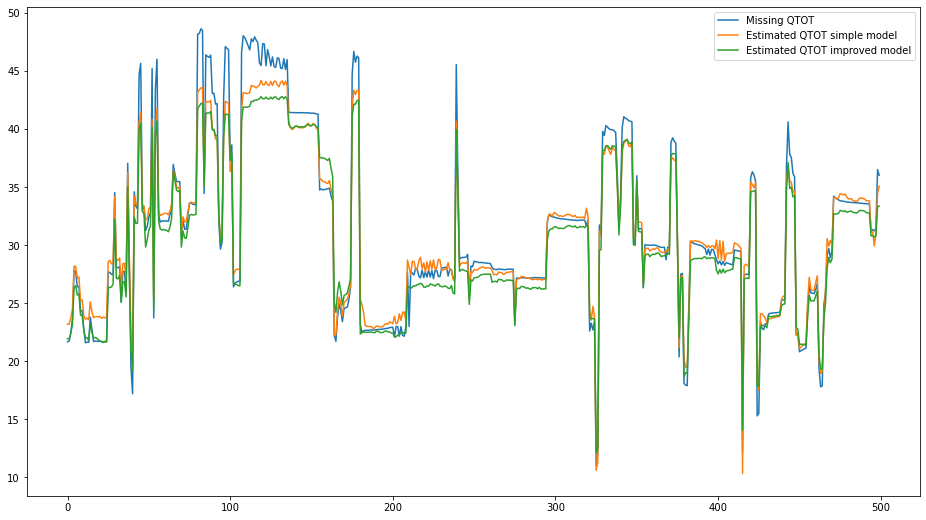

In [25]:
plt.figure(figsize=(16,9))
plt.plot(y_test.values, label='Missing QTOT')
plt.plot(keras_predictions, label='Estimated QTOT simple model')
plt.plot(improved_keras_predictions, label='Estimated QTOT improved model')
plt.legend()

In [26]:
import numpy as np
from tabulate import tabulate

m = np.array([["MSE", mse_test_simple, mse_test_improved],["MAE", mae_test_simple, mae_test_improved ],["MAPE", mape_test_simple, mape_test_improved]]);

headers = ["old", "new"]

table = tabulate(m, headers, tablefmt="fancy_grid")

print(table)


╒══════╤═════════╤═════════╕
│      │     old │     new │
╞══════╪═════════╪═════════╡
│ MSE  │ 2.27832 │ 3.36771 │
├──────┼─────────┼─────────┤
│ MAE  │ 1.01958 │ 1.30552 │
├──────┼─────────┼─────────┤
│ MAPE │ 3.15584 │ 3.85441 │
╘══════╧═════════╧═════════╛
